In [1]:
import torch
import torchvision
from tqdm import tqdm
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
from data.FloorPlanLoader import *
from model.VQAE import VQAE
from utils import *
from train import *

#Reproducability Checks:
random.seed(0) #Python
torch.manual_seed(0) #Torch
np.random.seed(0) #NumPy

### Hyperparameters

In [2]:
#Hyperparameter
batch_size = 128
n_hiddens = 32
n_residual_hiddens = 32
n_residual_layers = 1
embedding_dim = 64
n_embeddings = 218
beta = .25
lr = 3e-3
noise=False
noise_weight=0.05
img_channel=3

### Load Dataset

In [3]:
#Load Dataset
floor = FloorPlanDataset(multi_scale=True, root='../data/data_root/data00/',\
                         data_config='../data/data_config/', preprocess=True)
data_variance = floor.var
val_len = int(len(floor)/10)
train_set, val_set = torch.utils.data.random_split(floor, [len(floor)-val_len, val_len])

print(f"data shape: {floor[0]['image_tensor'].shape}, dataset size: {len(floor)}, data variance: {data_variance}")

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
validation_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = False)

data shape: torch.Size([3, 112, 112]), dataset size: 22995, data variance: 0.023186298087239265


In [4]:
floor.meta_info['AgeLabel'].describe()

count    1.048575e+06
mean     2.537797e-01
std      5.565936e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.000000e+00
Name: AgeLabel, dtype: float64

### Load Best or Train

In [5]:
vqvae = VQAE(n_hiddens, n_residual_hiddens, n_residual_layers,
                n_embeddings, embedding_dim, 
                beta, img_channel).to(device)
optimizer = torch.optim.Adam(vqvae.parameters(), lr=lr, amsgrad=False)
train_res_recon_error = []
test_res_recon_error = []
start_epoch = 0
end_epoch = 300
best_loss = 2

##### load best checkpoint

In [6]:
vqvae.load_state_dict(torch.load("../best_checkpoint/45-vqae-0.06130623703367973.pt"))
optimizer.load_state_dict(torch.load("../best_checkpoint/45-adam-0.06130623703367973.pt"))

with open("../best_checkpoint/45-vqae_train-0.06130623703367973.json") as json_file:
    train_res_recon_error = json.load(json_file)
with open("../best_checkpoint/45-vqae_test-0.06130623703367973.json") as json_file:
    test_res_recon_error = json.load(json_file)
    
start_epoch = 10
end_epoch = 300
best_loss = 0.06130623703367973

##### train

In [15]:
for epoch in range(start_epoch+1, end_epoch+1):
    with tqdm(train_loader, unit="batch") as tepoch:
        vqvae.train()
        for data_dict in tepoch:
            data = data_dict['image_tensor']
            data_no_noise = data.to(device)
            optimizer.zero_grad()

            if noise:
                data = add_noise(data_no_noise, noise_weight=noise_weight)
            else:
                data = data_no_noise
            vq_loss, data_recon, perplexity = vqvae(data)
            recon_error = F.mse_loss(data_recon, data) / data_variance
            loss = recon_error + vq_loss
            loss.backward()

            optimizer.step()
            tepoch.set_postfix(loss=float(loss.detach().cpu()))
            train_res_recon_error.append(recon_error.item())

    avg_loss = 0
    vqvae.eval()
    with torch.no_grad():
        for data_dict in validation_loader:
            data = data_dict['image_tensor']
            data = data.to(device)

            vq_loss, data_recon, perplexity = vqvae(data)
            recon_error = F.mse_loss(data_recon, data) / data_variance
            loss = recon_error.item() * batch_size

            avg_loss += loss / val_len
            test_res_recon_error.append(loss)
            
    if epoch%5==0 and avg_loss<best_loss:
        best_loss = avg_loss
        best_epoch = epoch
        torch.save(vqvae.state_dict(), f"../checkpoint/{best_epoch}-vqae-{best_loss}.pt")
        torch.save(optimizer.state_dict(), f"../checkpoint/{best_epoch}-adam-{best_loss}.pt")
        with open(f"../checkpoint/{best_epoch}-vqae_train-{best_loss}.json", 'w', encoding ='utf8') as json_file:
            json.dump(train_res_recon_error, json_file, ensure_ascii = False)
        with open(f"../checkpoint/{best_epoch}-vqae_test-{best_loss}.json", 'w', encoding ='utf8') as json_file:
            json.dump(test_res_recon_error, json_file, ensure_ascii = False)

    print(f'Validation Loss: {avg_loss}')

100%|█████████████████████████████████████████████████████████████████| 162/162 [04:47<00:00,  1.78s/batch, loss=0.186]


Validation Loss: 0.13590895149592683


100%|█████████████████████████████████████████████████████████████████| 162/162 [04:43<00:00,  1.75s/batch, loss=0.208]


Validation Loss: 0.13020087221800217


100%|█████████████████████████████████████████████████████████████████| 162/162 [04:37<00:00,  1.72s/batch, loss=0.159]


Validation Loss: 0.12387249520572696


100%|█████████████████████████████████████████████████████████████████| 162/162 [04:06<00:00,  1.52s/batch, loss=0.158]


Validation Loss: 0.12165366550692791


100%|██████████████████████████████████████████████████████████████████| 162/162 [04:10<00:00,  1.54s/batch, loss=0.17]


Validation Loss: 0.1117564255696579


100%|█████████████████████████████████████████████████████████████████| 162/162 [04:14<00:00,  1.57s/batch, loss=0.165]


Validation Loss: 0.10824115383153174


100%|█████████████████████████████████████████████████████████████████| 162/162 [05:25<00:00,  2.01s/batch, loss=0.165]


Validation Loss: 0.10451652341015498


100%|█████████████████████████████████████████████████████████████████| 162/162 [04:38<00:00,  1.72s/batch, loss=0.171]


Validation Loss: 0.10377782611755662


100%|█████████████████████████████████████████████████████████████████| 162/162 [04:54<00:00,  1.82s/batch, loss=0.169]


Validation Loss: 0.1006971813897145


100%|█████████████████████████████████████████████████████████████████| 162/162 [05:18<00:00,  1.97s/batch, loss=0.182]


Validation Loss: 0.09719674075982428


100%|█████████████████████████████████████████████████████████████████| 162/162 [05:07<00:00,  1.90s/batch, loss=0.176]


Validation Loss: 0.09618815197639746


100%|█████████████████████████████████████████████████████████████████| 162/162 [05:07<00:00,  1.90s/batch, loss=0.182]


Validation Loss: 0.09186715362070956


100%|█████████████████████████████████████████████████████████████████| 162/162 [04:59<00:00,  1.85s/batch, loss=0.177]


Validation Loss: 0.09084370178780177


100%|█████████████████████████████████████████████████████████████████| 162/162 [04:52<00:00,  1.80s/batch, loss=0.176]


Validation Loss: 0.09032533686282375


100%|█████████████████████████████████████████████████████████████████| 162/162 [04:12<00:00,  1.56s/batch, loss=0.195]


Validation Loss: 0.08651846063920031


100%|██████████████████████████████████████████████████████████████████| 162/162 [04:17<00:00,  1.59s/batch, loss=0.19]


Validation Loss: 0.08231952305512098


100%|█████████████████████████████████████████████████████████████████| 162/162 [05:08<00:00,  1.91s/batch, loss=0.185]


Validation Loss: 0.08248361684592614


100%|█████████████████████████████████████████████████████████████████| 162/162 [06:15<00:00,  2.32s/batch, loss=0.162]


Validation Loss: 0.07845784353660261


100%|█████████████████████████████████████████████████████████████████| 162/162 [05:13<00:00,  1.94s/batch, loss=0.174]


Validation Loss: 0.07767334955056991


100%|█████████████████████████████████████████████████████████████████| 162/162 [05:25<00:00,  2.01s/batch, loss=0.181]


Validation Loss: 0.07623670079387651


100%|█████████████████████████████████████████████████████████████████| 162/162 [05:23<00:00,  2.00s/batch, loss=0.174]


Validation Loss: 0.0776144113163162


100%|█████████████████████████████████████████████████████████████████| 162/162 [05:56<00:00,  2.20s/batch, loss=0.167]


Validation Loss: 0.07478841961648683


100%|█████████████████████████████████████████████████████████████████| 162/162 [09:13<00:00,  3.42s/batch, loss=0.166]


Validation Loss: 0.07161347645165972


100%|█████████████████████████████████████████████████████████████████| 162/162 [05:48<00:00,  2.15s/batch, loss=0.176]


Validation Loss: 1.849025260059146


100%|█████████████████████████████████████████████████████████████████| 162/162 [05:27<00:00,  2.02s/batch, loss=0.164]


Validation Loss: 0.07131127328030594


100%|█████████████████████████████████████████████████████████████████| 162/162 [05:21<00:00,  1.99s/batch, loss=0.167]


Validation Loss: 0.06869180039666745


100%|█████████████████████████████████████████████████████████████████| 162/162 [06:03<00:00,  2.25s/batch, loss=0.151]


Validation Loss: 0.06598737666066598


100%|█████████████████████████████████████████████████████████████████| 162/162 [05:30<00:00,  2.04s/batch, loss=0.151]


Validation Loss: 0.06587276587334859


100%|█████████████████████████████████████████████████████████████████| 162/162 [05:17<00:00,  1.96s/batch, loss=0.154]


Validation Loss: 0.06480224820104254


100%|█████████████████████████████████████████████████████████████████| 162/162 [05:28<00:00,  2.03s/batch, loss=0.162]


Validation Loss: 0.07277099440127884


100%|█████████████████████████████████████████████████████████████████| 162/162 [05:26<00:00,  2.01s/batch, loss=0.148]


Validation Loss: 0.06892058972744072


100%|█████████████████████████████████████████████████████████████████| 162/162 [05:01<00:00,  1.86s/batch, loss=0.158]


Validation Loss: 0.06287898017614496


100%|█████████████████████████████████████████████████████████████████| 162/162 [05:15<00:00,  1.94s/batch, loss=0.166]


Validation Loss: 0.10053314816282852


100%|█████████████████████████████████████████████████████████████████| 162/162 [05:27<00:00,  2.02s/batch, loss=0.144]


Validation Loss: 0.1831838550542738


100%|█████████████████████████████████████████████████████████████████| 162/162 [05:27<00:00,  2.02s/batch, loss=0.137]


Validation Loss: 0.06130623703367973


100%|█████████████████████████████████████████████████████████████████| 162/162 [05:29<00:00,  2.03s/batch, loss=0.143]


Validation Loss: 0.06745391537076029


100%|█████████████████████████████████████████████████████████████████| 162/162 [05:55<00:00,  2.19s/batch, loss=0.147]


Validation Loss: 0.27005244317703947


 40%|██████████████████████████                                        | 64/162 [02:05<03:12,  1.96s/batch, loss=0.557]


KeyboardInterrupt: 

### Visualization

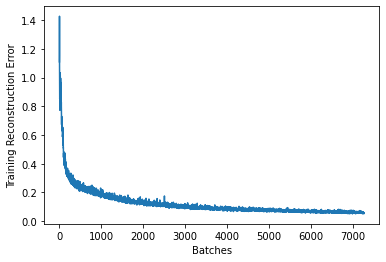

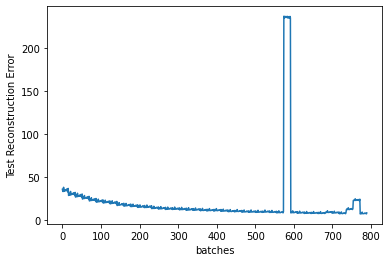

In [18]:
plt.plot(train_res_recon_error[20:])
plt.xlabel('Batches')
plt.ylabel('Training Reconstruction Error')
plt.show()

plt.plot(test_res_recon_error[20:])
plt.xlabel('batches')
plt.ylabel('Test Reconstruction Error')
plt.show()

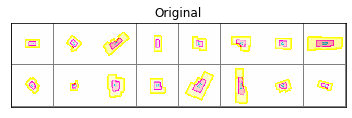

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


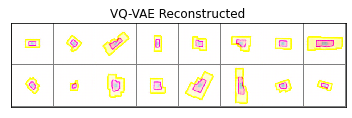

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


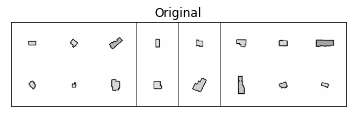

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


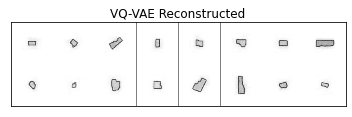

In [37]:
vqvae.eval()
temp_loader = torch.utils.data.DataLoader(val_set,batch_size=16,shuffle=True)
(valid_originals) = next(iter(temp_loader))
valid_originals = valid_originals['image_tensor'].to(device)

_, valid_recon, _ = vqvae(valid_originals)

def show(img, title):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.set_title(title)


show(torchvision.utils.make_grid(valid_originals.cpu()) + 0.5, "Original")
plt.show()
show(torchvision.utils.make_grid(valid_recon.cpu().data) + 0.5, "VQ-VAE Reconstructed")
plt.show()

def rescale_img(multi_scaled_channels): #B,C,H,W
    composed_1 = transforms.Resize(700)
    composed_2 = transforms.Compose([
                                    transforms.Resize(224),
                                    transforms.Pad(238, fill=1.0)])
    composed_3 = transforms.Pad(294, fill=1.0)
    composed_0 = transforms.Compose([transforms.Grayscale(),
                        transforms.CenterCrop(224)])
    
    channel_1 = composed_1(multi_scaled_channels[:,0:1,:,:])
    channel_2 = composed_2(multi_scaled_channels[:,1:2,:,:])
    channel_3 = composed_3(multi_scaled_channels[:,2:3,:,:])
    return composed_0(torch.cat([channel_1,channel_2,channel_3], dim=1))

valid_originals = rescale_img(valid_originals)
valid_recon = rescale_img(valid_recon)

show(torchvision.utils.make_grid(valid_originals.cpu())+0.5, "Original")
plt.show()
show(torchvision.utils.make_grid(valid_recon.cpu().data) + 0.5, "VQ-VAE Reconstructed")
plt.show()